# Complete age groups detailed model

- 11 age groups from TABNET
- high season with tranamission, low season with no transmission, deterministic
- Plotting the infected over time and the age pattern of infection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
np.random.seed(123)

In [2]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [3]:
@np.vectorize
def beta_cos(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  return beta_0*np.cos(2*np.pi*t/365)+beta_aug

In [4]:
def modify_initial_condition(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[3*N:4*N] = (y_aux[3*N:4*N]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [5]:
def modify_initial_condition_2(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[4] = (y_aux[4]*pop - 1)/pop # suscteptible reduction
    y_tmp[N+4] = (y_aux[N+4]*pop + 1)/pop # infected grow
    y_tmp[3*N+4] = (y_aux[3*N+4]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [6]:
def n_groups_seasonal_model(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    return np.array([dSdt, dIdt, dRdt,dCdt]).flatten()

## Defining data for the model

### Determining demographical parameters

In [7]:
def calculate_l_vector(alpha,l1):
    list_l = [] # creando uma lista l l1, l2, l3, .....
    elements_l = alpha.shape[0]
    for i in range(elements_l):
        # if it is the first element
        if(i == 0):
            list_l.append(l1)
        elif(i == elements_l-1): # if it is the last element (mortality term)
            list_l.append(list_l[-1]*alpha[-2]/alpha[-1])
        else: # in other case (intermediate elements)
            list_l.append(list_l[-1]*alpha[i-1]/alpha[i])
    return list_l

In [8]:
# number of age groups
N = 11

# number of people per age group
alpha1 = 793061 # 0 to 4 
alpha2 = 803773 # 5 to 9
alpha3 = 836496 # 10 to 14
alpha4 = 877970 # 15 to 19
alpha5 = 1960304 # 20 to 29
alpha6 = 1995084 # 30 to 39
alpha7 = 1666076 # 40 to 49
alpha8 = 1319655 # 50 to 59
alpha9 = 878162 # 60 to 59
alpha10 = 476538 # 70 to 79 
alpha11 = 245667 # 80+

# creating vector of alphas
alpha_pop = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])

# total population 
pop = alpha_pop.sum()

# dividing by total population
alpha1 = alpha1/pop
alpha2 = alpha2/pop
alpha3 = alpha3/pop
alpha4 = alpha4/pop
alpha5 = alpha5/pop
alpha6 = alpha6/pop
alpha7 = alpha7/pop
alpha8 = alpha8/pop
alpha9 = alpha9/pop
alpha10 = alpha10/pop
alpha11 = alpha11/pop

# creating a new vector of alphas (divided by overall population, as proportions)
alpha = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])


# demographical constants for the model
l1 = 1/(365*5) # how long does the first age group last (in days)?
nu = l1*alpha[0] # calculating the corresponding birth rate
l_vec = calculate_l_vector(alpha, l1) # calculating l aging elements + coupled death rate
mu_vec = np.array([0,0,0,0,0,0,0,0,0,0, l_vec[-1]]) # death rates array
# calculating aging rates vector
l_vec = l_vec[:-1] 
l_vec.append(0)
l_vec = np.array(l_vec)

### Defining epidemiological parameters

In [9]:
# constructs initial condition with one infected adult in the 20-29 age range
def define_initial_condition():
    y0 = np.array([alpha1,alpha2,alpha3,alpha4,(alpha5*pop-1)/pop,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0])
    return y0

In [10]:
# initial conditions - one infected adult in 20-29
y0 = define_initial_condition()

# disease parameters
gamma = 1/(7.0)
beta_aug = 2.7*gamma
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 20

## Running simulations - Attempt 1: not quite perfect

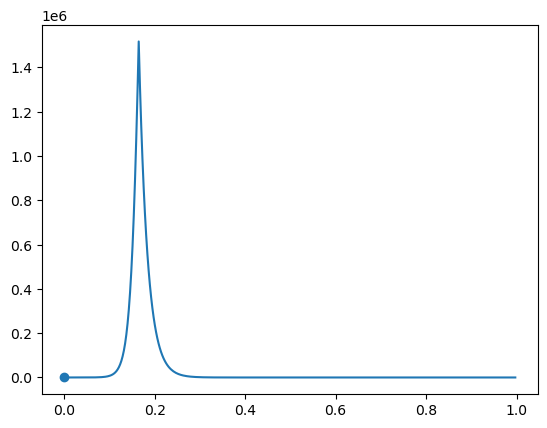

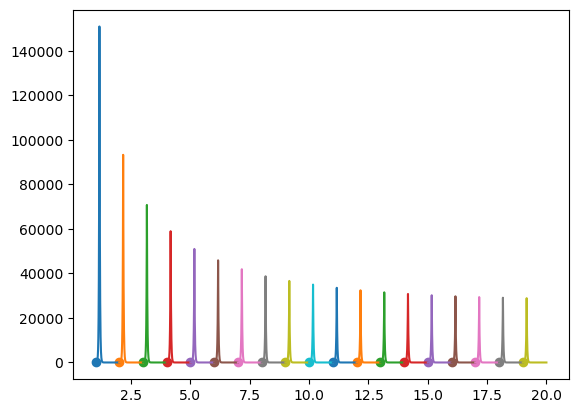

In [11]:
y0 = define_initial_condition()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
    plt.scatter((season*365)/365,y0[N:2*N].sum())
    if(season == 0):
        plt.show()
#plt.legend()
plt.show()

[ 793061.  803773.  836496.  877970. 1960304. 1995084. 1666076. 1319655.
  878162.  476538.  245667.]
[18.5845067  21.72737124 21.98996361 22.00403949 22.00462489 22.00459874
 22.00459605 22.00459592 22.00459591 22.00459591 22.00459591]


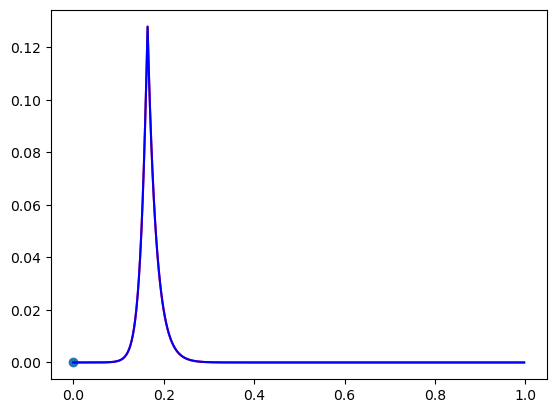

[17.3904265  23.28621547 24.31924837 24.43796102 24.44813858 24.44841726
 24.44842874 24.44844283 24.44847524 24.44854723 24.44866736]
[15.67050121 23.49414058 25.56869479 25.93264785 25.98137856 25.98365651
 25.98375465 25.98378488 25.98384577 25.98397375 25.98417214]
[13.97184203 23.04726303 26.25468428 27.01019762 27.14907552 27.15802166
 27.15850272 27.15856582 27.15865285 27.15882503 27.15907665]
[12.42995871 22.23280323 26.54338855 27.81616314 28.11599449 28.14064173
 28.14228275 28.14243939 28.14255456 28.14276249 28.14305177]
[11.06275442 21.19917266 26.50918932 28.39171347 28.93620608 28.99084111
 28.99521902 28.99562551 28.99578191 28.99602065 28.99633787]
[ 9.87691446 20.05860125 26.22297309 28.77027258 29.64875971 29.75319957
 29.76302291 29.76400608 29.76424039 29.76451008 29.76484951]
[ 8.85212466 18.87501563 25.73199636 28.96349984 30.2642629  30.44358228
 30.46299174 30.46514348 30.46553579 30.4658453  30.46620505]
[ 7.96901822 17.69363825 25.08048818 28.98464663 30.789

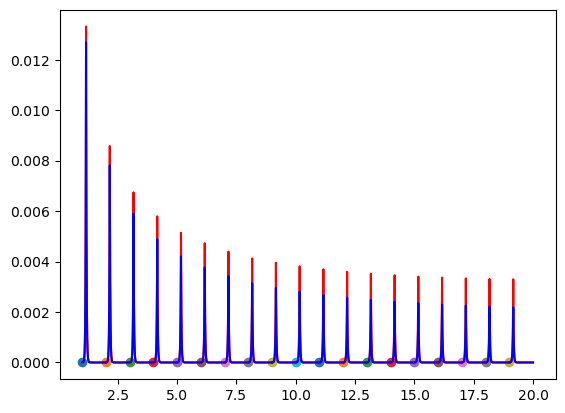

In [12]:
y0 = define_initial_condition()
print(alpha*pop)
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    plt.plot((t_season_single+season*365)/365,ret[:,N]/alpha[0], label = 'ch', color = 'red')
    plt.plot((t_season_single+season*365)/365,ret[:,2*N-1]/alpha[-1], label = 'old', color = 'blue')
    plt.scatter((season*365)/365,y0[N:2*N].sum())
    print(100*ret[-1,2*N:3*N]/alpha)
    #print(100*ret[-1,2*N:3*N]/ret[-1,2*N:3*N].sum())
    if(season == 0):
        plt.show()
#plt.legend()
plt.show()

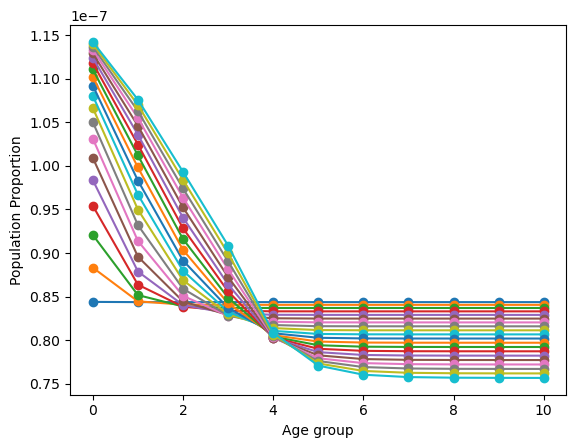

In [13]:
y0 = define_initial_condition()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
    #print((ret[364,10:]*pop - ret[0,10:]*pop).sum())
    prop_pop = alpha*pop*inf_total
    plt.plot((pop/prop_pop)*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 0), '-o', label = season)
    plt.ylabel('Population Proportion')
    plt.xlabel('Age group')
    #plt.legend()
plt.show()